In [1]:
import numpy as np
import matplotlib
import random
matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
random.seed(42)

In [2]:
# Target Policy for player
def target_policy_player(pl_ace_flag, pl_sum, dl_card):
    return pl_policy[pl_sum]
# Random behaviour Policy for player
def behavior_policy_player(pl_ace_flag, pl_sum, dl_card):
    if np.random.binomial(1, 0.5) == 1:
        return stand
    return hit
# draw card from the Deck.
def drawCard():
    card = np.random.randint(1, 13)
    if card > 10:
        card = 10    
    return card
# Game 
def blackjack(policy_player, initial_state=None, initial_action=None):
    pl_sum = 0
    pl_history = []
    pl_ace_flag = False # True --> player use ace as 11 otherwise 1
    dl_card1 = 0
    dl_card2 = 0
    dl_ace_flag = False
    if initial_state is None:
        n_ace = 0
        while pl_sum < 12:
            card = drawCard()
            if card == 1:
                n_ace += 1
                card = 11
                pl_ace_flag = True
            pl_sum += card
        if pl_sum > 21:
            pl_sum -= 10
            if n_ace == 1:
                pl_ace_flag = False
        #get dealer cards
        dl_card1 = drawCard()
        dl_card2 = drawCard()
    else:
        pl_ace_flag, pl_sum, dl_card1 = initial_state
        dl_card2 = drawCard()

    state = [pl_ace_flag, pl_sum, dl_card1]
        
    
    dl_sum = 0
    if dl_card1 == 1 and dl_card2 != 1:
        dl_sum += 11 + dl_card2
        dl_ace_flag = True
    elif dl_card1 != 1 and dl_card2 == 1:
        dl_sum += dl_card1 + 11
        dl_ace_flag = True
    elif dl_card1 == 1 and dl_card2 == 1:
        dl_sum += 1 + 11
        dl_ace_flag = True
    else:
        dl_sum += dl_card1 + dl_card2
   
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            action = policy_player(pl_ace_flag, pl_sum, dl_card1)
        pl_history.append([(pl_ace_flag, pl_sum, dl_card1), action])

        if action == stand:
            break
         # HIT   
        pl_sum += drawCard()
        # BUSTS
        if pl_sum > 21:
            #  Avoid busting
            if pl_ace_flag == True:
                pl_sum -= 10
                pl_ace_flag = False
            else:
                # Player loses
                return state, -1, pl_history
    # dealer's turn
    while True:
        # get action based on current sum
        action = dl_policy[dl_sum]
        if action == stand:
            break
        # HIT
        new_card = drawCard()
        if new_card == 1 and dl_sum + 11 < 21:
            dl_sum += 11
            dl_ace_flag = True
        else:
            dl_sum += new_card
        # BUST
        if dl_sum > 21:
            if dl_ace_flag == True:
            #  Avoid busting and continue
                dl_sum -= 10
                dl_ace_flag = False
            else:
            # otherwise dealer loses
                return state, 1, pl_history
     # compare the sum between player and dealer
    if pl_sum > dl_sum:
        return state, 1, pl_history
    elif pl_sum == dl_sum:
        return state, 0, pl_history
    else:
        return state, -1, pl_history
   

In [3]:
def MC_ON_POLICY(episodes):
    values_usable_ace = np.zeros((10, 10))
    values_usable_ace_count = np.ones((10, 10))
    values_no_usable_ace = np.zeros((10, 10))
    values_no_usable_ace_count = np.ones((10, 10))
    for i in range(0, episodes):
        _, reward, pl_history = blackjack(target_policy_player)
        for (usable_ace, pl_sum, dl_card), _ in pl_history:
            pl_sum -= 12
            dl_card -= 1
            if usable_ace:
                values_usable_ace_count[pl_sum, dl_card] += 1
                values_usable_ace[pl_sum, dl_card] += reward
            else:
                values_no_usable_ace_count[pl_sum, dl_card] += 1
                values_no_usable_ace[pl_sum, dl_card] += reward
    return values_usable_ace / values_usable_ace_count, values_no_usable_ace / values_no_usable_ace_count

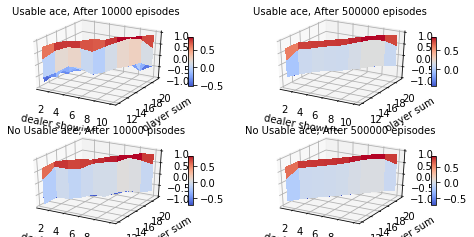

In [4]:
# Define Actions
hit= 0
stand = 1
actions = [hit,stand]

# The Policy that Sticks if the player's sum is 20 or 21 and hit othewise
pl_policy = np.zeros(22)
for i in range(12, 20):
    pl_policy[i] = hit
pl_policy[20] = stand
pl_policy[21] = stand
# Dealer hits and sticks according to a fixed stratergy without choice: 
dl_policy = np.zeros(22)
for i in range(12, 17): 
    dl_policy[i] = hit
for i in range(17, 22):
    dl_policy[i] = stand # sticks on any sum of 17 or greater
Value_Function_UsableAce_1, Value_Function_No_UsableAce_1 = MC_ON_POLICY(10000)
Value_Function_UsableAce_2, Value_Function_No_UsableAce_2 = MC_ON_POLICY(500000)
Values = [Value_Function_UsableAce_1,Value_Function_UsableAce_2,Value_Function_No_UsableAce_1,Value_Function_No_UsableAce_2]
titles = ['Usable ace, After 10000 episodes','Usable ace, After 500000 episodes','No Usable ace, After 10000 pisodes','No Usable ace, After 500000 episodes']
index = [1,2,3,4]
fig = plt.figure(figsize=plt.figaspect(0.5))
for value, title, a in zip(Values, titles, index):
    ax = fig.add_subplot(2, 2, a, projection='3d')
    surf = ax.plot_surface(range(1,11), range(12,22), value, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.set_zlim(-1.01, 1.01)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.ylabel('player sum', fontsize=10)
    plt.xlabel('dealer showing', fontsize=10)
    plt.title(title, fontsize=10)

plt.savefig('5_1.png')
plt.show()